In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import numpy as np
from utils import * 

In [5]:


# Function to split data and move files
def split_data(class_dir, dest_base_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Get a list of all images

    images = os.listdir(class_dir)
    images_full_paths = [os.path.join(class_dir, img) for img in images]

    # Split the list of images
    train_images, test_images = train_test_split(images_full_paths, test_size=1 - train_ratio, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Function to copy files to a target directory
    def copy_files(files, target_dir):
        os.makedirs(target_dir, exist_ok=True)
        for f in files:
            shutil.copy(f, target_dir)

    # Copy files to the respective directories
    copy_files(train_images, os.path.join(dest_base_dir, 'train', os.path.basename(class_dir)))
    copy_files(val_images, os.path.join(dest_base_dir, 'valid', os.path.basename(class_dir)))
    copy_files(test_images, os.path.join(dest_base_dir, 'test', os.path.basename(class_dir)))


base_dir = 'basketballDetection-18/cropped_for_cls'
combined_path = os.path.join(base_dir, 'combined')

dest_base_dir = os.path.join(base_dir, 'split')

split_data(os.path.join(combined_path, '0'), dest_base_dir)
split_data(os.path.join(combined_path, '1'), dest_base_dir)


In [10]:
for split in os.listdir(dest_base_dir):
    print(f"{split}: {len(os.listdir(dest_base_dir + '/' + split + '/0')) + len(os.listdir(dest_base_dir + '/' + split + '/1'))}")

train: 3539
valid: 1012
test: 507


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomResizedCrop(size=224),  # Perform a random crop and resize it back to 224x224
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    transforms.RandomErasing(p=0.5),  # Randomly erase a portion of the image
])

test_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

base_dir = 'basketballDetection-18/cropped_for_cls'
combined_path = os.path.join(base_dir, 'combined')

dest_base_dir = os.path.join(base_dir, 'split')


train_dataset = datasets.ImageFolder(root=os.path.join(dest_base_dir, 'train'), transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=os.path.join(dest_base_dir, 'valid'), transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(dest_base_dir, 'test'), transform=test_val_transforms)



batch_size = 32 
num_workers = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)




In [5]:
num_classes = 2

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
training_history = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=100)


Epoch [2/100]	 Avg Loss: 0.3368	 TrainAcc: 0.8505 	 TestAcc: 0.9328	 Time: 6.9385
Epoch [4/100]	 Avg Loss: 0.2964	 TrainAcc: 0.8765 	 TestAcc: 0.9565	 Time: 6.9967
Epoch [6/100]	 Avg Loss: 0.2596	 TrainAcc: 0.8966 	 TestAcc: 0.9684	 Time: 7.0898
Epoch [8/100]	 Avg Loss: 0.2509	 TrainAcc: 0.8982 	 TestAcc: 0.9555	 Time: 6.9710
Epoch [10/100]	 Avg Loss: 0.2489	 TrainAcc: 0.8960 	 TestAcc: 0.8182	 Time: 7.2302
Epoch [12/100]	 Avg Loss: 0.2351	 TrainAcc: 0.9110 	 TestAcc: 0.9496	 Time: 6.8384
Epoch [14/100]	 Avg Loss: 0.1976	 TrainAcc: 0.9268 	 TestAcc: 0.9348	 Time: 6.7771
Epoch [16/100]	 Avg Loss: 0.2137	 TrainAcc: 0.9112 	 TestAcc: 0.9615	 Time: 6.9013
Epoch [18/100]	 Avg Loss: 0.2016	 TrainAcc: 0.9254 	 TestAcc: 0.9694	 Time: 6.7640
Epoch [20/100]	 Avg Loss: 0.1943	 TrainAcc: 0.9240 	 TestAcc: 0.9654	 Time: 6.9619
Epoch [22/100]	 Avg Loss: 0.1880	 TrainAcc: 0.9271 	 TestAcc: 0.9644	 Time: 6.7016
Epoch [24/100]	 Avg Loss: 0.1881	 TrainAcc: 0.9282 	 TestAcc: 0.9595	 Time: 6.8312
Epoch [2

In [11]:
#model = torch.load("cls_model.pth", map_location=torch.device('mps')).to("mps")

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    print(f"Test Accuracy: {100 * correct / total}")
    

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 16.87it/s]

Test Accuracy: 98.224853515625


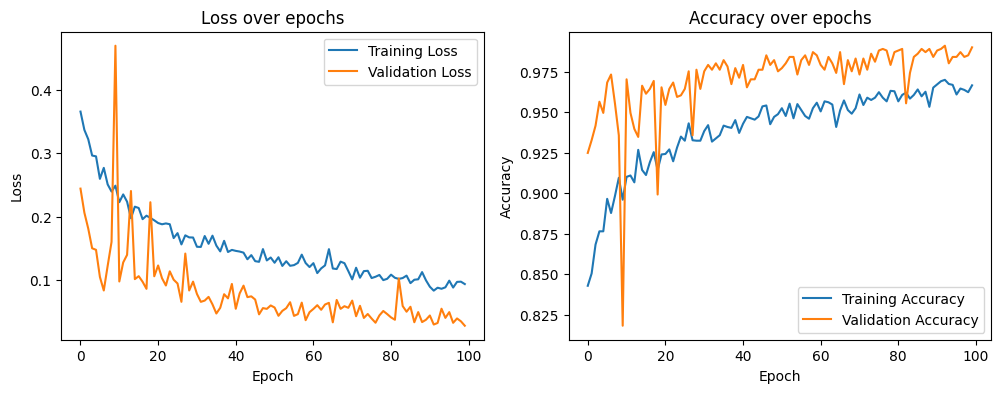

In [8]:
plot_training_history((training_history))

In [9]:
# Save the entire model
torch.save(model, 'cls_model.pth')


In [9]:
training_history

{'train_loss': array([0.36559596, 0.33676756, 0.32200248, 0.29635726, 0.29504944,
        0.25962178, 0.27692758, 0.25086196, 0.23958231, 0.24886239,
        0.22285515, 0.23508186, 0.22363109, 0.19757277, 0.21577861,
        0.21365571, 0.19609909, 0.20159195, 0.19805775, 0.19426151,
        0.18998948, 0.18803212, 0.18936566, 0.18812414, 0.1662771 ,
        0.17409159, 0.15630709, 0.17060605, 0.16736538, 0.16717976,
        0.15259581, 0.15232763, 0.1695229 , 0.15727253, 0.17006915,
        0.15444734, 0.14529609, 0.16193321, 0.14432147, 0.14766864,
        0.14612593, 0.14505983, 0.14333074, 0.13287485, 0.13944443,
        0.12992726, 0.12888116, 0.14893006, 0.13108277, 0.13567466,
        0.12744061, 0.13608451, 0.1223992 , 0.12982491, 0.12261805,
        0.12365938, 0.12718001, 0.1401671 , 0.12695591, 0.12063781,
        0.12677299, 0.11110143, 0.11849722, 0.12326018, 0.14885625,
        0.11831162, 0.11751113, 0.12914863, 0.12672198, 0.11420262,
        0.1012407 , 0.11955125, 0.